In [1]:
from utils.nrrd2nii import nrrd2nii

AAAlabel = nrrd2nii("data/uwa_aaa/Patient1/Segmentation/CT_AAA_label.nrrd").get_fdata()
Bloodlabel = nrrd2nii("data/uwa_aaa/Patient1/Segmentation/CT_blood_label.nrrd").get_fdata()
image = nrrd2nii("data/uwa_aaa/Patient1/Segmentation/CT_cropped.nrrd").get_fdata()

In [2]:
from utils.check_image import check_image

check_image(
    [
        {"image": image, "title": "image", "is_label": False},
        {"image": AAAlabel + Bloodlabel, "title": "label", "is_label": True},
    ]
)

interactive(children=(IntSlider(value=0, description='slice_index_0', max=125), IntSlider(value=0, description…

In [74]:
import torch
from torch_synthseg.random_spatial_deformation import RandomSpatialDeformation
from torch_synthseg.sample_condition_gmm import SampleConditionGMM

label = torch.tensor(AAAlabel + Bloodlabel, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
spatial_transform = RandomSpatialDeformation()
label_deformed = spatial_transform(label)
gmm = SampleConditionGMM()
image = gmm(label)

In [75]:
check_image(
    [
        {"image": image[0, 0], "title": "label"},
        {"image": label_deformed[0, 0], "title": "label_deformed", "is_label": True},
    ]
)

interactive(children=(IntSlider(value=0, description='slice_index_0', max=125), IntSlider(value=0, description…

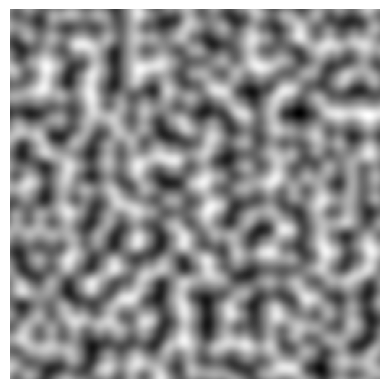

In [66]:
import matplotlib.pyplot as plt

def generate_perlin_noise_2d(shape, res):
    def f(t):
        return 6*t**5 - 15*t**4 + 10*t**3
    
    delta = (res[0] / shape[0], res[1] / shape[1])
    d = (shape[0] // res[0], shape[1] // res[1])
    grid = torch.stack(torch.meshgrid(torch.arange(0, res[0], delta[0]), torch.arange(0, res[1], delta[1])), dim=-1) % 1
    
    # Gradients
    angles = 2*torch.pi*torch.rand(res[0]+1, res[1]+1)
    gradients = torch.stack((torch.cos(angles), torch.sin(angles)), dim=-1)
    
    g00 = gradients[:-1,:-1].repeat_interleave(d[0], 0).repeat_interleave(d[1], 1)
    g10 = gradients[1:,:-1].repeat_interleave(d[0], 0).repeat_interleave(d[1], 1)
    g01 = gradients[:-1,1:].repeat_interleave(d[0], 0).repeat_interleave(d[1], 1)
    g11 = gradients[1:,1:].repeat_interleave(d[0], 0).repeat_interleave(d[1], 1)
    
    # Ramps
    n00 = torch.sum(torch.stack((grid[:,:,0], grid[:,:,1]), dim=-1) * g00, dim=2)
    n10 = torch.sum(torch.stack((grid[:,:,0]-1, grid[:,:,1]), dim=-1) * g10, dim=2)
    n01 = torch.sum(torch.stack((grid[:,:,0], grid[:,:,1]-1), dim=-1) * g01, dim=2)
    n11 = torch.sum(torch.stack((grid[:,:,0]-1, grid[:,:,1]-1), dim=-1) * g11, dim=2)
    
    # Interpolation
    t = f(grid)
    n0 = n00*(1-t[:,:,0]) + t[:,:,0]*n10
    n1 = n01*(1-t[:,:,0]) + t[:,:,0]*n11
    return 4*((1-t[:,:,1])*n0 + t[:,:,1]*n1)

# Set image size and resolution
shape = torch.tensor([256, 256])
res = torch.tensor([16, 16])

# Generate the noise
noise = generate_perlin_noise_2d(shape, res)

# Normalize to [0, 1] range
noise = (noise - noise.min()) / (noise.max() - noise.min())

# Display the image
plt.imshow(noise.detach().numpy(), cmap='gray')
plt.axis('off')
plt.show()
